# Full Name:  Çağdaş Güven


# Student ID: 2738938

# Find words of certain patterns: Scrabble with ME536 flavor
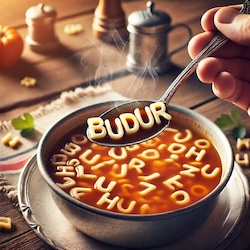


# as usual, start with imports

You are not allowed to import additional libraries, but you can import other sub-libraries for conveinence

In [1]:
# import usual suspects
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as pimg # check this out this is new
from numpy import cos, arccos, sin, pi, round
from numpy.linalg import matrix_rank as rank
from numpy.linalg import svd, eig
from scipy.linalg import orth
from scipy.ndimage import convolve
import cv2 as cv
from skimage import io
from skimage.filters import threshold_otsu as otsu
from PIL import Image, ImageDraw, ImageFont
from PIL import Image # if needed more can be importaed
import sklearn as skl # famous sci-kit learn
import skimage as ski # equally famous sci-kit image
!rm bug_numpy_utils.py 2>/dev/null  # at the first run file does not exits but error should print
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
from bug_numpy_utils import MatPrint, CData, text2mat # note that once these files are downloaded you can read their content.
from bug_numpy_utils import DrawOnImage as DrawIt
!rm me536utils.py 2>/dev/null  # at the first run file does not exits but error should print
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/me536utils.py
from me536utils import RotMat

# my imports
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops

--2024-12-22 16:17:28--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18456 (18K) [text/plain]
Saving to: ‘bug_numpy_utils.py’

bug_numpy_utils.py  100%[===================>]  18.02K  --.-KB/s    in 0.006s  

2024-12-22 16:17:28 (2.81 MB/s) - ‘bug_numpy_utils.py’ saved [18456/18456]

--2024-12-22 16:17:29--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/me536utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3130 (3.1K

## Let's get started with generating a test image
Test images to functions you will write can be generated using the following code.  

Some of the paramters will not change, yet play with the changable parameters to see what kind of different images can be generated with it.  

Note that at the end a __box__ and a __line__ is also drawn on the image to demonstrate the usage of already provided (imported) function: ```DrawIt()```.

So all utilities are already provided, so that you can focus on the tast itself!

In [252]:
# in the assignment assessment following will not change in test images
fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
cellSize = 30 #cell within which a single char will be printed
BackColor = (255,255, 255) # back color
ForeColor = (0, 0, 0) # font color

charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
#charz = ['R' ]
# in the assignment assessment variable above will not change in generating test images

# CHANGABLE PARAMETER
xCount, yCount = 15, 10 # number of cells

# prompt: generate a list that is 10 by 15 that that contains * in each element
charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign

# CHANGABLE PARAMETER
numLetters = 1500 #well obvious

# CHANGABLE PARAMETER
fixedFontSize = False #if variable font size will be used

fR = 0.8 # font ratio to cell size
fontsize = int(cellSize * fR) # fixed font size
nB = int(cellSize*(1-fR)) # location noise

img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

pos = [] # keep track of occupied cells
for i in range(numLetters): # draw each letter if random location is not already occupied, if occupied, skip
    if not fixedFontSize: # if set so, select a random font size
        fontsize = np.random.randint(12, cellSize-1)
        dx, dy = 0, 0 # when scaled, position does not change
    else: # add some location noise
        dx = int(np.random.rand()* nB)
        dy = int(np.random.rand()* nB)
    font = ImageFont.truetype(fontname, fontsize) # font instace created
    txt = random.choice(charz)
    x = np.random.randint(0, xCount)
    y = np.random.randint(0, yCount)
    if (x,y) not in pos:
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image
        pos.append((x,y))

img = np.array(img) # convert PIL image to numpy for future numpy stuff, this is what I will pass to your function



# '''
# The following is to be used in generating the resulting image in your function
# Note that you will need more colors, and location of lines and boxes will be determined by your function
# '''
# # generate 2 sample pens
# penRed = (255,0, 0)
# penGreen = (0,255,0)

# # a green box with no diagonals
# img = DrawIt(img, ((90, 90),(120, 120)), box=True, diagonals = False, dpen=penGreen)
# # finally a blue line
# img = DrawIt(img, ((30, 30),(105, 105)), dpen = penRed)



# # finally plot the image
# plt.figure(figsize=(12,9))
# plt.imshow(img)


# Your assignment starts here

You are to write 1 function to which an image generated by the code above will be passed along with one of the following words: "KARE", "BUDUR" and "6KENAR".  
Note that all letters will be upper case.  

The stub of the function you are to complete is given below.  

If **KARE** is pased, your function at the end should:  
- Change the colors (i.e. 4 different colors in total) of all the letters in "KARE" for all instances of letters 'K', 'A', 'R' and 'E' so that we can see that your algorithm was able to find all relevant letters.
- Select the 4 letters 'K', 'A', 'R' and 'E' in a row, draw a fixed colored box around the selected letters and connect their centers with lines, so that when you follow the letters from 'K' to 'E' it should look like the best possible square within the given image. When connecting letters, finally connect 'E' to 'K' so that it properly looks like a polygon.

If **BUDUR** is passed, your function should:
- Similarly, change the colors (i.e. 5 differen colors in total) of all letters in "BUDUR" for all instances of 'B', 'U', 'D', 'U' and 'R'.  
- This time, you are trying to find the shortest path that connects the letters of the word "BUDUR". Once sequence is found, similarly put a colored box around all 6 letters and connect them with lines from 'B' all the way to 'R'.  Do not connect 'R' back to 'B', since this is a path.

If **6KENAR** is passed, your function should:
- Well, same deal goes on, change the colors of (i.e. 6 differen colors in total) of all '6', 'K', 'E', 'N', 'A' and 'R' for the same reason as above.
- Select the characters in such a way that, after placing 6 colored boxed and drawing 6 lines as define above, when the centers of the boxes from '6' all the way to 'R' and back to '6' are connected, it should be the largest possile 6 sided [convex polygon](https://mathworld.wolfram.com/ConvexPolygon.html) (irregular convex hexagon) within the given image. In other words, you are not looking for a perfect, i.e. equilateral hexagon, but any convex 6 sided polygon with the largest area is what you are looking for.

Note that in all of the above cases, letters should be sorted. For example if the solution is given for 'BUDUR', Starting from letter 'B' if we follow the lines one after the other, we shoul visit 'U', 'D', 'U' and 'R'. The others are similar. So order matters!!!

Also note that for 'KARE' and '6KENAR' I expect you to explain clearly what measure you use and how you select the best fitting alternative.

If the passes string cannot be formed using the letters in the passed image (for example assume that letter 'E', does not exist at all, and passes text is "6KENAR"), then your code should seperately color all remaining letters in the image, i.e. all '6', 'K', 'N', 'A' and 'R' letters should be colored, different letters, different colors, same letters same color.

You are expected to fill in the ```SearchInAlphabetSoup()``` function, yet you can write as many support functions you like below, but at the end please put all your code in **ONE CODE CELL** so that we can start testing your code after running only the following cell.

## Explanation of how to solve 'KARE' case:  



## Explanation of how to solve the '6KENAR' case:  



In [3]:
# all of your support code in this box... in case needed

# Helper function to draw boxes and connect centers
def draw_boxes_and_lines(img, coords, color_map, connect_last=True):
    """
    Draws colored boxes around given coordinates and connects their centers with lines.
    """
    for i, coord in enumerate(coords):
        minr, minc, maxr, maxc = coord
        cv.rectangle(img, (minc, minr), (maxc, maxr), color_map[i], 2)
        center = ((minc + maxc) // 2, (minr + maxr) // 2)
        if i > 0:
            prev_center = ((coords[i-1][1] + coords[i-1][3]) // 2, (coords[i-1][0] + coords[i-1][2]) // 2)
            cv.line(img, prev_center, center, color_map[i], 2)
        if i == len(coords) - 1 and connect_last:
            first_center = ((coords[0][1] + coords[0][3]) // 2, (coords[0][0] + coords[0][2]) // 2)
            cv.line(img, center, first_center, color_map[i], 2)
    return img


In [4]:
def SearchInAlphabetSoup(img, txt="KARE"):
    """
    Search for characters in an image and map them to the given text (txt).
    
    Args:
        img (ndarray): Input image in RGB format.
        txt (str): Target word (e.g., 'KARE').
    
    Returns:
        result (ndarray): Image with detected letters highlighted in specific colors.
        addresses (dict): Dictionary of addresses for each letter in the given text.
    """
    # Constants
    fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
    cellSize = 30  # Size of each cell in the image grid
    colors = {ch: tuple(np.random.randint(0, 256, 3).tolist()) for ch in txt}
    addresses = {ch: [] for ch in txt}
    
    # Create character templates
    templates = {}
    fontsize = int(cellSize * 0.8)  # 80% of cell size for font
    for char in charz:
        font = ImageFont.truetype(fontname, fontsize)
        char_img = Image.new("RGB", (cellSize, cellSize), BackColor)
        draw = ImageDraw.Draw(char_img)
        draw.text((5, 5), char, font=font, fill=ForeColor)  # Draw slightly inset
        templates[char] = np.array(char_img.convert("L"))  # Convert to grayscale
    
    # Convert input image to grayscale and threshold it
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)
    
    # Find contours
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    print(f"Total contours detected: {len(contours)}")
    
    # Initialize result image
    result = img.copy()
    
    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)
        if w > cellSize or h > cellSize:  # Skip if contour exceeds cell size
            continue

        # Extract and resize the detected region
        char_img = binary[y:y+h, x:x+w]
        resized_char = cv.resize(char_img, (cellSize, cellSize), interpolation=cv.INTER_AREA)

        # Match against templates
        detected_char = None
        max_score = 0
        for char, template in templates.items():
            # Measure similarity (e.g., using normalized cross-correlation)
            score = np.sum(resized_char == template) / (cellSize * cellSize)
            if score > max_score and score > 0.7:  # Set a threshold for matching
                detected_char = char
                max_score = score

        print(f"Contour {i}: Bounding box = (x={x}, y={y}, w={w}, h={h}), Detected character = {detected_char}")

        if detected_char is not None and detected_char in txt:  # Check if detected_char is valid
            # Map character to the corresponding color
            color = colors[detected_char]
            cv.rectangle(result, (x, y), (x + w, y + h), color, -1)
            # Store address
            addresses[detected_char].append((x // cellSize, y // cellSize))



## A sample test

In [70]:
from sklearn.cluster import KMeans
import cv2 as cv
import numpy as np

def process_word_image(img_path, word, debug=True):
    """
    Clusters characters in an image and highlights letters in the given word.

    Args:
        img_path (str): Path to the input image.
        word (str): Target word for clustering.
        debug (bool): Enable debug mode.

    Returns:
        result (ndarray): Processed image with clusters.
    """
    num_clusters = len(set(word)) + 2  # Unique letters + unrelated + background

    # Load and preprocess the image
    img_read = cv.imread(img_path)
    if img_read is None:
        raise ValueError(f"Image at path '{img_path}' could not be loaded.")
    gray = cv.cvtColor(img_read, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)

    # Detect contours for segmentation
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    character_imgs = []
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        char_img = binary[y:y+h, x:x+w]
        char_resized = cv.resize(char_img, (20, 20))
        character_imgs.append(char_resized.flatten())

    if len(character_imgs) < num_clusters:
        raise ValueError("Too few clusters identified. Check the input image or preprocessing.")

    # Perform K-Means clustering
    character_array = np.array(character_imgs)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(character_array)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    if debug:
        print(f"KMeans Centers:\n{centers}")

    # Map clusters to colors
    label_to_color = {i: (np.random.randint(0, 255), 
                          np.random.randint(0, 255), 
                          np.random.randint(0, 255)) for i in range(num_clusters)}

    # Highlight target word clusters
    for char in set(word):
        # Assign distinct colors to letters in the word
        label = kmeans.predict([np.array(char).flatten()])
        label_to_color[label[0]] = (255, 0, 0)  # Red, for example

    # Apply clustering results to the image
    result = img_read.copy()
    for i, cnt in enumerate(contours):
        x, y, w, h = cv.boundingRect(cnt)
        color = label_to_color[labels[i]]
        cv.rectangle(result, (x, y), (x+w, y+h), color, 2)

    return result


In [241]:
def SearchInAlphabetSoup_Hu_Color(img, txt='KARE'):
    """
    Search for letters in the given image based on Hu moments and color them.
    Args:
        img (ndarray): Input image.
        txt (str): Word to search for in the image.
    Returns:
        result (ndarray): Processed image with detected letters colored.
        addresses (dict): Dictionary of detected letter addresses.
    """
    import cv2 as cv
    import numpy as np

    # Reference Hu moments for known characters
    reference_hu_moments = {
        'K': [2.96010755  , 6.94906786 , 10.11911532 , 10.62768259 ,-12., -11.99672589 , 12.],
        'A': [2.9619816  ,  7.26473138 ,  9.18647435 , 11.16697955 ,-12.,  11.99941747 , 12],
        '6': [2.98596906 ,  6.89468478 , 10.4988344  , 11.30320345 ,-12., -11.99969131 ,-12.],
        'B': [3.01209861 , 7.02534156 ,10.91654653, 11.84651875,     12.,  11.99998056, 12.],
        'D': [2.92340801 ,  6.86960773 , 10.131772   , 11.60386621 ,-12. ,-11.99976977 ,-12.],
        'E': [2.91151497  , 6.52036571 , 10.38315578  ,10.60248756 ,-12., -11.99516884 , 12.],
        'U': [2.93318599 ,  7.03895723 , 10.39722718 , 10.80500237 ,-12. , 11.99906914 ,-12.],
        'R': [2.97116618 ,  7.05089972 , 10.90547477  ,10.88396242  ,12. , 11.99870308, -12.],
        'N': [3.01294821 ,  7.30971082 , 11.98604284 , 11.64804209 ,-12. , 11.99990164 , 12.] 
    }

    # Define colors for each character
    colors = {
        'K': (255, 0, 0),   # Red
        'A': (0, 255, 0),   # Green
        'R': (0, 0, 255),   # Blue
        'E': (255, 255, 0), # Yellow
        'B': (255, 0, 255), # Magenta
        'U': (0, 255, 255), # Cyan
        'D': (128, 0, 128), # Purple
        '6': (128, 128, 0), # Olive
        'N': (0, 128, 128)  # Teal
    }

    # Convert to grayscale and binary
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Initialize result image and addresses
    result = img.copy()
    addresses = {char: [] for char in txt}

    # Define cell size
    cellSize = 30
    threshold_margin = 1.5  # Increase margin for better detection

    print(f"Total contours detected: {len(contours)}")

    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)

        # Extract the ROI and calculate Hu moments
        roi = binary[y:y + h, x:x + w]
        moments = cv.moments(roi)
        hu_moments = cv.HuMoments(moments).flatten()

        # Normalize Hu moments
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-12)
        print(f"Hu Moments: {hu_moments}")
        # Compare with reference Hu moments
        detected_char = None
        min_distance = float('inf')
        for char, ref_hu in reference_hu_moments.items():
            distance = np.linalg.norm(np.array(hu_moments[:6]) - np.array(ref_hu[:6]))
            if distance < min_distance:
                min_distance = distance
                detected_char = char

        # Apply threshold margin for detection
        if detected_char and min_distance < threshold_margin:
            print(f"Contour {i}: Bounding box = (x={x}, y={y}, w={w}, h={h}), Detected character = {detected_char}, Min distance = {min_distance}")
            if detected_char in txt:
                addresses[detected_char].append((x // cellSize, y // cellSize))

                # Change the letter's color by masking its region
                letter_mask = binary[y:y + h, x:x + w]
                color = colors[detected_char]
                result[y:y + h, x:x + w][letter_mask > 0] = color

    print(f"Addresses for {txt}: {addresses}")

    return result, addresses



Total contours detected: 150
Hu Moments: [  3.02180598   7.49264423  11.06654149  11.05402679  12.
  11.99981334 -12.        ]
Contour 0: Bounding box = (x=421, y=275, w=12, h=14), Detected character = R, Min distance = 0.5025616451425418
Hu Moments: [  2.95856174   7.2228826   11.19475844  11.13353714 -12.
  11.99933721 -12.        ]
Contour 1: Bounding box = (x=92, y=275, w=13, h=17), Detected character = U, Min distance = 0.882305926245812
Hu Moments: [  2.9794425    7.38326838  10.89911064  11.01441091  12.
  11.9994805  -12.        ]
Contour 2: Bounding box = (x=331, y=274, w=11, h=13), Detected character = R, Min distance = 0.3572048934711366
Hu Moments: [  3.02890052   7.4830317   11.4928226   11.28149781  12.
  11.99997255 -12.        ]
Contour 3: Bounding box = (x=301, y=274, w=9, h=11), Detected character = R, Min distance = 0.8325171313911032
Hu Moments: [  2.9794425    7.38326838  10.89911064  11.01441091  12.
  11.9994805  -12.        ]
Contour 4: Bounding box = (x=211, y=

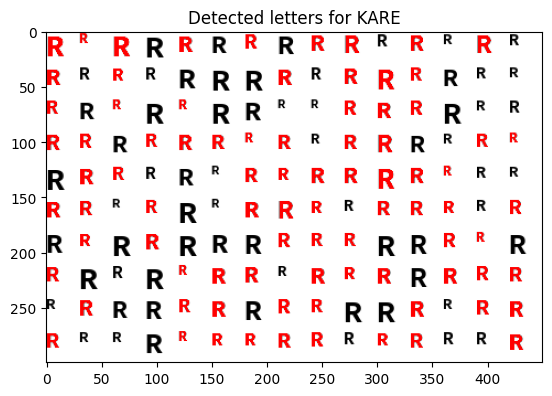

In [242]:
# Assuming `img` is generated using your provided image generation code
text1 = "KARE"
result1, addresses1 = SearchInAlphabetSoup_Hu_Color(img, text1)

plt.imshow(cv.cvtColor(result1, cv.COLOR_BGR2RGB))
plt.title(f"Detected letters for {text1}")
plt.show()


In [119]:
import numpy as np

# Detected Hu Moments for cells
hu_moments_cells = [
    [3.12910129e-01, 3.96882984e-03, 1.46227726e-03, 7.09210574e-04, -5.80865158e-07, -4.22253121e-05, 4.29205062e-07],
    [2.15157111e-01, 3.20754140e-03, 5.20013653e-06, 5.47435010e-04, 2.29183858e-08, 3.03712625e-05, -1.81072407e-08],
    [2.30907584e-01, 3.33639974e-03, 1.96823580e-04, 1.31561982e-03, 3.91342005e-08, 7.58631739e-05, -6.68329932e-07],
    [2.42639694e-01, 3.99375457e-03, 8.12668033e-03, 3.68096134e-04, -6.09389525e-07, 2.29725125e-05, 1.84291595e-07],
    [4.61883333e-01, 1.52345806e-03, 5.34391311e-03, 1.10326689e-03, -2.67862040e-06, 4.22849676e-05, -3.60830425e-08],
    [3.36458094e-01, 6.27944883e-03, 3.88823553e-03, 6.64957839e-04, -9.94916573e-07, -5.13140237e-05, 3.91630424e-07],
    [3.41877673e-01, 7.16528415e-03, 2.68276507e-06, 1.58878693e-05, 7.21939115e-11, -4.71393195e-07, 7.44797297e-11],
    [2.80141333e-01, 6.03635057e-03, 1.27394383e-02, 1.88839031e-03, -7.15864174e-06, 1.46029154e-04, 5.87721502e-06],
    [1.81848354e-01, 4.14020738e-03, 8.40350844e-05, 1.75383064e-06, -9.52592436e-13, 6.45164939e-08, -2.12704516e-11],
    [4.14348109e-01, 7.59676212e-03, 2.21221430e-03, 4.84128838e-04, -5.00866285e-07, 4.20995583e-05, 1.24082225e-08],
]

# Replace these with actual Hu moments for each corresponding character ('K', 'A', '6', 'B', etc.)
actual_hu_moments = {
    'K': [3.30941200e-01 , 9.42664854e-03 , 3.12730579e-03 , 7.41589063e-04 ,-1.12763843e-06, -7.20014167e-05 , 6.22282384e-08],
    'A': [2.42711326e-01 , 3.29188413e-03 , 7.82829093e-03 , 4.76873726e-04 ,-8.88599575e-07 , 2.73078815e-05  ,2.43579725e-07], 
    '6': [2.25670644e-01 , 6.99636361e-03 , 8.00610036e-04  ,8.51029182e-04 , 6.99247322e-07 , 6.23181339e-05 ,-6.72007962e-08],
    'B': [1.82538688e-01 , 4.75489632e-03 , 8.16495288e-05  ,2.72938457e-06 , 3.69141836e-11 , 1.88085751e-07 ,-1.72480478e-11],
    'D': [1.76431620e-01 , 3.97355947e-03  ,2.51568945e-04  ,1.15063028e-05, -6.05443541e-10 ,-7.19023821e-07  ,1.29121893e-10],
    'E': [4.32865746e-01 , 4.49229412e-02 , 2.68709153e-03 , 1.64046020e-03, -2.81429367e-06, -3.02649772e-04 , 1.98553318e-06],
    'U': [3.98535048e-01 , 1.04938746e-02 , 1.35384428e-03 , 9.89079796e-04 ,-9.79206122e-08 , 1.96714393e-05 ,-1.14034453e-06],
    'R': [2.25274417e-01 , 3.92644017e-03 , 9.11165875e-05 , 9.84490526e-04  ,1.32448281e-07 , 6.10340891e-05, -2.63438687e-07],
    'N': [3.24611196e-01 , 6.25995019e-03 , 8.39568621e-06 , 6.42762429e-05 ,-7.74789482e-10 , 3.22222639e-06 , 1.27640203e-09],
}
#charz = ['', 'U', '', 'R', '', '', '', '', 'N']

# Actual characters for each cell
actual_characters = ['K', 'A', '6', 'B', 'D', 'E', 'K', 'B', 'E', 'K']

# Compute Euclidean distances
distances = []
for i, hu_cell in enumerate(hu_moments_cells):
    actual_char = actual_characters[i]
    actual_hu = actual_hu_moments.get(actual_char, None)
    if actual_hu:
        distance = np.sqrt(np.sum((np.array(hu_cell) - np.array(actual_hu))**2))
        distances.append((i, actual_char, distance))
    else:
        distances.append((i, actual_char, None))

# Output results
for i, char, dist in distances:
    if dist is not None:
        print(f"Cell {i}: Detected character '{char}', Euclidean Distance = {dist:.6f}")
    else:
        print(f"Cell {i}: Detected character '{char}', No reference Hu moments found.")


Cell 0: Detected character 'K', Euclidean Distance = 0.018912
Cell 1: Detected character 'A', Euclidean Distance = 0.028643
Cell 2: Detected character '6', Euclidean Distance = 0.006434
Cell 3: Detected character 'B', Euclidean Distance = 0.060643
Cell 4: Detected character 'D', Euclidean Distance = 0.285510
Cell 5: Detected character 'E', Euclidean Distance = 0.103876
Cell 6: Detected character 'K', Euclidean Distance = 0.011620
Cell 7: Detected character 'B', Euclidean Distance = 0.098447
Cell 8: Detected character 'E', Euclidean Distance = 0.254328
Cell 9: Detected character 'K', Euclidean Distance = 0.083432


In [273]:
def DrawSquareFromText_NoCollision_WithBoxes(img, txt, addresses, cell_size=30):
    """
    Draw a square connecting the centers of the cells containing the characters in the given text,
    ensuring angles are close to 90 degrees and edges do not collide.
    Additionally, draw a box around the chosen cells and change the color of chosen letters to orange.

    Args:
        img (ndarray): Input image.
        txt (str): Text to draw the square for (e.g., "KARE").
        addresses (dict): Dictionary of detected letter addresses.
        cell_size (int): Size of each cell in the grid.

    Returns:
        img_with_square (ndarray): Image with the square drawn.
    """
    import numpy as np

    # Helper function to calculate cell center
    def get_cell_center(cell):
        return (cell[1] * cell_size + cell_size // 2, cell[0] * cell_size + cell_size // 2)

    # Helper function to check edge intersection
    def edges_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        
        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    # Extract centers for each character in the text
    centers = {char: [get_cell_center(cell) for cell in addresses[char]] for char in txt}

    # If any character is not detected, return the original image
    if any(len(centers[char]) == 0 for char in txt):
        print(f"Error: One or more characters in {txt} are not detected.")
        return img

    # Find the best configuration of cell centers that form a square
    best_square = None
    best_score = float('inf')

    for k_center in centers[txt[0]]:
        for a_center in centers[txt[1]]:
            for r_center in centers[txt[2]]:
                for e_center in centers[txt[3]]:
                    # Calculate angles for all corners
                    angle_k = calculate_angle(e_center, k_center, a_center)
                    angle_a = calculate_angle(k_center, a_center, r_center)
                    angle_r = calculate_angle(a_center, r_center, e_center)
                    angle_e = calculate_angle(r_center, e_center, k_center)

                    # Check for edge collisions
                    if edges_intersect(k_center, a_center, r_center, e_center):
                        continue
                    if edges_intersect(a_center, r_center, e_center, k_center):
                        continue

                    # Check if angles are close to 90 degrees and similar to each other
                    angles = [angle_k, angle_a, angle_r, angle_e]
                    mean_angle = np.mean(angles)
                    angle_deviation = np.std(angles)  # Variation between angles
                    score = abs(mean_angle - 90) + angle_deviation

                    if score < best_score:
                        best_score = score
                        best_square = (k_center, a_center, r_center, e_center)

    if best_square:
        # Draw the square and highlight chosen cells
        img_with_square = img.copy()

        # Draw the square
        img_with_square = DrawIt(img_with_square, (best_square[0], best_square[1]), box=False, diagonals=False, dpen=(255, 0, 0))
        img_with_square = DrawIt(img_with_square, (best_square[1], best_square[2]), box=False, diagonals=False, dpen=(0, 255, 0))
        img_with_square = DrawIt(img_with_square, (best_square[2], best_square[3]), box=False, diagonals=False, dpen=(0, 0, 255))
        img_with_square = DrawIt(img_with_square, (best_square[3], best_square[0]), box=False, diagonals=False, dpen=(255, 255, 0))

        # Draw boxes around selected cells and change the color of letters inside
        selected_cells = [addresses[txt[0]][0], addresses[txt[1]][0], addresses[txt[2]][0], addresses[txt[3]][0]]
        for cell, char_center in zip(selected_cells, best_square):
            # Clip box coordinates to the image dimensions
            img_height, img_width = img.shape[:2]
            box_coords = (
                (max(0, min(cell[0] * cell_size, img_height - 1)), max(0, min(cell[1] * cell_size, img_width - 1))),
                (max(0, min((cell[0] + 1) * cell_size, img_height - 1)), max(0, min((cell[1] + 1) * cell_size, img_width - 1)))
            )
            img_with_square = DrawIt(img_with_square, box_coords, box=True, diagonals=False, dpen=(0, 165, 255))

            # Change the letter's color
            x, y = char_center
            img_with_square[y - cell_size // 2:y + cell_size // 2, x - cell_size // 2:x + cell_size // 2] = [0, 165, 255]

        return img_with_square

    print("No valid square configuration found.")
    return img


def calculate_angle(p1, p2, p3):
    """
    Calculate the angle formed by three points (p1 -> p2 -> p3).

    Args:
        p1, p2, p3 (tuple): Points as (x, y).

    Returns:
        angle (float): Angle in degrees.
    """
    import numpy as np

    # Vectors
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

    # Calculate the angle
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip for numerical stability
    return np.degrees(angle)




In [253]:
def SearchInAlphabetSoup_Hu_Color(img, txt='KARE'):
    """
    Search for letters in the given image based on Hu moments and color them using multiple reference moments.
    Args:
        img (ndarray): Input image.
        txt (str): Word to search for in the image.
        reference_hu_moments (dict): Dictionary containing multiple Hu moment references for each character.
    Returns:
        result (ndarray): Processed image with detected letters colored.
        addresses (dict): Dictionary of detected letter addresses.
    """
    import cv2 as cv
    import numpy as np

    # Reference Hu moments for known characters (if not provided externally)
    reference_hu_moments=None

    if reference_hu_moments is None:
        reference_hu_moments = {
            'R': [
            [2.99337424, 7.37441974, 11.49610793, 11.15684756, -12., 11.99959664, -12.],
            [2.99819389, 7.18990667, 11.37563441, 11.15438167, 12., 11.99955274, -12.],
            [3.00293021, 7.23328647, 11.60703302, 11.20708134, -12., 11.99949215, -12.],
            [3.02180598, 7.49264423, 11.06654149, 11.05402679, 12., 11.99981334, -12.],
            [2.95856174, 7.2228826, 11.19475844, 11.13353714, -12., 11.99933721, -12.],
            [3.02180598, 7.49264423, 11.06654149, 11.05402679, 12., 11.99981334, -12.],
            [2.97116618, 7.05089972, 10.90547477, 10.88396242, 12., 11.99870308, -12.],
            [2.98172651, 7.44007234, 11.43527447, 10.98473779, 12., 11.99947495, -12.],
            [2.97116618, 7.05089972, 10.90547477, 10.88396242, 12., 11.99870308, -12.],
            [2.9861125, 7.22016021, 11.15788965, 11.20814166, 12., 11.99979985, -12.]
    ],
            'B': [
            [3.00640564, 7.17381556, 10.98021093, 11.86583584, -12., 11.99996283, 12.],
            [2.9731605, 6.94182847, 11.02548256, 11.78251691, -12., 11.99990488, 12.],
            [2.99780934, 7.01905498, 11.07342144, 11.90761205, -12., 11.99996904, 12.],
            [2.98469476, 7.05281015, 10.80878881, 11.9772553, -12., -11.99999372, -12.],
            [2.99330435, 7.01698556, 10.82322186, 11.75383154, 12., 11.9999893, -12.],
            [2.99330435, 7.01698556, 10.82322186, 11.75383154, 12., 11.9999893, -12.],
            [3.0192444, 7.4303944, 10.9420488, 11.68960313, 12., -11.99991294, 12.],
            [3.01209861, 7.02534156, 10.91654653, 11.84651875, 12., 11.99998056, 12.],
            [3.0041089, 7.20432312, 10.91756631, 11.84952106, -12., 11.99996271, -12.],
            [2.98051719, 7.22155248, 10.93982636, 11.49273447, -12., 11.99996089, -12.]
    ],
            'U': [
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.94840854, 7.64026168, 10.13563288, 10.7562245, -12., 11.99964574, 12.],
            [2.93660685, 7.30327783, 10.27246636, 10.68193869, 12., 11.99970407, 12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.93318599, 7.03895723, 10.39722718, 10.80500237, -12., 11.99906914, -12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.9497132, 7.13331803, 10.36393817, 11.14940597, -12., 11.99928372, -12.]
    ],
            'D': [
            [2.9084599, 6.96149022, 10.0521984, 11.30194296, -12., -11.99944716, -12.],
            [2.95753146, 7.01708874, 10.22160862, 11.46446138, -12., -11.99970016, 12.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.94111029, 7.12690735, 10.19089953, 11.87114148, 12., 11.99998115, -12.],
            [2.92340801, 6.86960773, 10.131772, 11.60386621, -12., -11.99976977, -12.],
            [2.92340801, 6.86960773, 10.131772, 11.60386621, -12., -11.99976977, -12.],
            [2.98932668, 7.20351484, 10.30523049, 11.88963167, -12., -11.99996856, -12.],
            [2.95644284, 7.15427152, 10.15573452, 11.979795, -12., 11.99999951, 12.]
    ],
            'K': [
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [3.00113588, 7.34264773, 10.59911877, 10.58052349, -12., -11.99769337, 12.],
            [2.95769602, 7.10405808, 10.02161954, 10.56740793, -12., -11.99702514, 12.],
            [2.97171965, 6.99304696, 10.26616856, 10.73675528, -12., -11.99764933, 12.],
            [3.00113588, 7.34264773, 10.59911877, 10.58052349, -12., -11.99769337, 12.],
            [2.96010755, 6.94906786, 10.11911532, 10.62768259, -12., -11.99672589, 12.],
            [2.95623471, 7.13358849, 10.4803107, 10.51900689, -12., -11.99672277, 12.],
            [3.00476809, 7.08902742, 10.60881822, 10.79691926, -12., -11.99817015, 12.]
    ],
     #aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


            'A': [
            [  2.96356354  , 7.27730944  , 9.15974507 , 11.1055351  ,-12. , 11.99932451 , 12.        ],
            [  2.96356354 ,  7.27730944  , 9.15974507 , 11.1055351 , -12. , 11.99932451 , 12.        ],
            [  2.96766208 ,  7.25726     , 9.20516206 , 11.23301135 ,-12. , 11.99950535 , 12.        ],
            [  2.9619816  ,  7.26473138  , 9.18647435 , 11.16697955 ,-12. , 11.99941747 , 12.        ],
            [  2.94737101  , 7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.94737101  , 7.17711621  , 9.20230938  ,10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.94737101 ,  7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.9987038  ,  7.36524797  , 9.28425017 , 11.46253624 ,-12. , 11.99977935 ,-12.        ],
            [ 2.99393918 , 7.37770734 , 9.23595474, 11.01256409 ,12.    ,     11.99947822 ,12.       ],
            [  2.96838801  , 7.16479765   ,9.23708667  ,11.0499672  ,-12. , 11.9991497  , 12.        ]
    ],
            # eeeeeeeeeeeeeeeeeeeeeeeeee
            'E':[
            [  2.90148216  , 6.61715167  ,10.23203413  ,10.33271991 ,-12., -11.9913422  , 12.        ],
            [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12., -11.99202422 , 12.        ],
            [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12. ,-11.99202422 , 12.        ],
            [  2.92161068  , 6.70722686  ,10.37386024  ,10.218256   ,-12. ,-11.98870168 , 12.        ],
            [  2.92161068  , 6.70722686  ,10.37386024 , 10.218256   ,-12., -11.98870168 , 12.        ],
            [  2.94198556  , 6.61182409 , 10.50385861  ,10.7712946  ,-12., -11.99664396 , 12.        ],
            [  2.91151497  , 6.52036571 , 10.38315578 , 10.60248756 ,-12., -11.99516884 , 12.        ],
            [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12. ,-11.99656509 , 12.        ],
            [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12., -11.99656509 , 12.        ],
            [  2.89595023  , 6.58100526 , 10.28892046  ,10.28788065 ,-12. ,-11.99076072 , 12.        ]
    ],
            #6666666666666666
            '6':[
            [  3.00662985  , 7.03678979 , 10.88341013 , 11.63884984 ,-12. ,-11.99983661 , 12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219, -12. ,-11.99965396 ,-12.        ],
            [  2.98219027  , 6.93772886 , 10.71097202 , 11.41980857 ,-12. ,-11.99963856 ,-12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114  ,11.37079219 ,-12., -11.99965396 ,-12.        ],
            [  2.98225369  , 6.91208366 , 10.55408089  ,11.20067104 ,-12., -11.99963034 ,-12.        ],
            [  2.98225369  , 6.91208366 , 10.55408089 , 11.20067104 ,-12., -11.99963034 ,-12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219 ,-12., -11.99965396 ,-12.        ],
            [  2.98596906  , 6.89468478 , 10.4988344   ,11.30320345 ,-12., -11.99969131 ,-12.        ],
            [  2.98596906  , 6.89468478 , 10.4988344  , 11.30320345, -12., -11.99969131 ,-12.        ],
            [  2.98001227  , 6.88787796 , 10.74909433 , 11.50636062 ,-12., -11.99967838 , 12.    ]
    ],
            # nnnnnnnnnnnnnnnnnnnnnnn
            'N':[
            [  2.98702975  , 7.16447196 , 11.99742085 , 11.99116862  ,12., -11.99999935 , 12.        ],
            [  2.99121239 ,  7.33051856,  11.96198954 , 11.84624536 , 12.,  11.99998375 , 12.        ],
            [  2.98702975 ,  7.16447196  ,11.99742085  ,11.99116862 , 12., -11.99999935 , 12.        ],
            [  2.98702975 ,  7.16447196  ,11.99742085 , 11.99116862  ,12. ,-11.99999935 , 12.        ],
            [  2.9972662  ,  7.15292041  ,11.29029402 , 11.58826937 ,-12., -11.99984397 , 12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12. , 11.99990164  ,12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284 , 11.64804209 ,-12.,  11.99990164 , 12.        ],
            [  3.00836829  , 7.46660531  ,11.97909214 , 11.74086408 , 12. , 11.99993908 ,-12.        ],
            [  3.00836829  , 7.46660531  ,11.97909214  ,11.74086408 , 12. , 11.99993908 ,-12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12.  ,11.99990164 , 12.        ]
    ],
            # Repeat for other characters...
        }

     # Define colors for each character
    colors = {
        'K': (255, 0, 0),   # Red
        'A': (0, 255, 0),   # Green
        'R': (0, 0, 255),   # Blue
        'E': (255, 255, 0), # Yellow
        'B': (255, 0, 255), # Magenta
        'U': (0, 255, 255), # Cyan
        'D': (128, 0, 128), # Purple
        '6': (128, 128, 0), # Olive
        'N': (0, 128, 128)  # Teal
    }

    # Convert to grayscale and binary
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Initialize result image and addresses
    result = img.copy()
    addresses = {char: [] for char in txt}

    # Define cell size
    cellSize = 30
    threshold_margin = 1.5  # Adjust threshold for better detection

    print(f"Total contours detected: {len(contours)}")

    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)

        # Extract the ROI and calculate Hu moments
        roi = binary[y:y + h, x:x + w]
        moments = cv.moments(roi)
        hu_moments = cv.HuMoments(moments).flatten()

        # Normalize Hu moments
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-12)
        print(f"Hu Moments for contour {i}: {hu_moments}")
        # Compare with reference Hu moments
        detected_char = None
        min_distance = float('inf')

        for char, ref_hus in reference_hu_moments.items():
            # Calculate the minimum distance for this character across its references
            char_min_distance = min(
                np.linalg.norm(np.array(hu_moments[:6]) - np.array(ref_hu[:6])) for ref_hu in ref_hus
            )
            if char_min_distance < min_distance:
                min_distance = char_min_distance
                detected_char = char

        # Apply threshold margin for detection
        if detected_char and min_distance < threshold_margin:
            print(f"Contour {i}: Bounding box = (x={x}, y={y}, w={w}, h={h}), Detected character = {detected_char}, Min distance = {min_distance}")
            if detected_char in txt:
                addresses[detected_char].append((x // cellSize, y // cellSize))

                # Change the letter's color by masking its region
                letter_mask = binary[y:y + h, x:x + w]
                color = colors[detected_char]
                result[y:y + h, x:x + w][letter_mask > 0] = color

    print(f"Addresses for {txt}: {addresses}")
    if txt == "KARE":
        result = DrawSquareFromText_NoCollision_WithBoxes(result, txt, addresses, cellSize)
    else:
        return result


Total contours detected: 150
Hu Moments for contour 0: [  2.9161667    7.31809027  10.24799455  10.8103928  -12.
  11.99862494 -12.        ]
Contour 0: Bounding box = (x=92, y=276, w=13, h=18), Detected character = U, Min distance = 4.603713167789911e-09
Hu Moments for contour 1: [  2.90148216   6.61715167  10.23203413  10.33271991 -12.
 -11.9913422   12.        ]
Contour 1: Bounding box = (x=32, y=276, w=14, h=18), Detected character = E, Min distance = 7.653613643967025e-09
Hu Moments for contour 2: [  3.00113588   7.34264773  10.59911877  10.58052349 -12.
 -11.99769337  12.        ]
Contour 2: Bounding box = (x=421, y=275, w=12, h=14), Detected character = K, Min distance = 8.085104661335176e-09
Hu Moments for contour 3: [  2.98946638   7.30741986  10.61916453  11.8517173   12.
 -11.99996508  12.        ]
Contour 3: Bounding box = (x=391, y=275, w=11, h=14), Detected character = D, Min distance = 0.3064307650852453
Hu Moments for contour 4: [  2.95753146   7.01708874  10.22160862  1

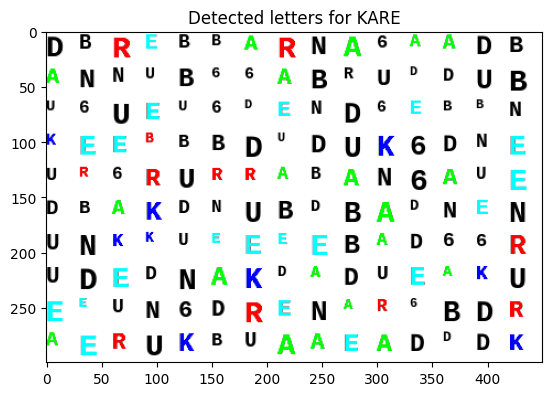

In [254]:
# Assuming `img` is generated using your provided image generation code
text1 = "KARE"
result1, addresses1 = SearchInAlphabetSoup_Hu_Color(img, text1)

plt.imshow(cv.cvtColor(result1, cv.COLOR_BGR2RGB))
plt.title(f"Detected letters for {text1}")
plt.show()

In [ ]:
# #rrrrrrrrrrRRRRRRRRRRRRRRRR

#  [  2.99337424  , 7.37441974  ,11.49610793 , 11.15684756 ,-12. , 11.99959664 ,-12.        ]
#  [  2.99819389  , 7.18990667  ,11.37563441  ,11.15438167 , 12. , 11.99955274 ,-12.        ]
#  [  3.00293021  , 7.23328647  ,11.60703302  ,11.20708134 ,-12. , 11.99949215 ,-12.        ]
#  [  3.02180598  , 7.49264423  ,11.06654149  ,11.05402679 , 12. , 11.99981334 ,-12.        ]
#  [  2.95856174  , 7.2228826   ,11.19475844  ,11.13353714 ,-12. , 11.99933721 ,-12.        ]
#  [  3.02180598  , 7.49264423  ,11.06654149 , 11.05402679 , 12. , 11.99981334 ,-12.        ]
#  [  2.97116618  , 7.05089972  ,10.90547477 , 10.88396242 , 12.  ,11.99870308 ,-12.        ]
#  [  2.98172651  , 7.44007234 , 11.43527447 , 10.98473779 , 12. , 11.99947495 ,-12.        ]
#  [  2.97116618  , 7.05089972 , 10.90547477 , 10.88396242 , 12. , 11.99870308 ,-12.        ]
#  [  2.9861125  ,  7.22016021 , 11.15788965 , 11.20814166 , 12. , 11.99979985 ,-12. ]

# #bbbbbbbbbbbbbbbb
#  [  3.00640564  , 7.17381556 , 10.98021093 , 11.86583584 ,-12.  ,11.99996283 , 12.        ]
#  [  2.9731605   , 6.94182847 , 11.02548256 , 11.78251691 ,-12. , 11.99990488  ,12.        ]
#  [  2.99780934  , 7.01905498 , 11.07342144 , 11.90761205 ,-12. , 11.99996904 , 12.        ]
#  [  2.98469476  , 7.05281015 , 10.80878881 , 11.9772553  ,-12. ,-11.99999372 -12.        ]
#  [  2.99330435  , 7.01698556 , 10.82322186 , 11.75383154 , 12. , 11.9999893 , -12.        ]
#  [  2.99330435  , 7.01698556 , 10.82322186 , 11.75383154 , 12. , 11.9999893 , -12.        ]
#  [  3.0192444  ,  7.4303944  , 10.9420488  , 11.68960313 , 12. ,-11.99991294 , 12.        ]
#  [ 3.01209861 , 7.02534156 ,10.91654653 ,11.84651875 ,12.       ,  11.99998056 ,12.        ]
#  [  3.0041089  ,  7.20432312  ,10.91756631  ,11.84952106 ,-12. , 11.99996271 ,-12.        ]
#  [  2.98051719  , 7.22155248  ,10.93982636  ,11.49273447 ,-12. , 11.99996089 ,-12.  ]

# #uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu

#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.94840854   7.64026168  10.13563288  10.7562245  -12.  11.99964574  12.        ]
#  [ 2.93660685  7.30327783 10.27246636 10.68193869 12.         11.99970407 12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.93318599   7.03895723  10.39722718  10.80500237 -12.  11.99906914 -12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.9497132    7.13331803  10.36393817  11.14940597 -12.  11.99928372 -12.  ]

# #dddddddddddddddddddddddddddd

#  [  2.9084599    6.96149022  10.0521984   11.30194296 -12. -11.99944716 -12.        ]
#  [  2.95753146   7.01708874  10.22160862  11.46446138 -12. -11.99970016  12.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.94111029   7.12690735  10.19089953  11.87114148  12.  11.99998115 -12.        ]
#  [  2.92340801   6.86960773  10.131772    11.60386621 -12. -11.99976977 -12.        ]
#  [  2.92340801   6.86960773  10.131772    11.60386621 -12. -11.99976977 -12.        ]
#  [  2.98932668   7.20351484  10.30523049  11.88963167 -12. -11.99996856 -12.        ]
#  [  2.95644284   7.15427152  10.15573452  11.979795   -12.  11.99999951  12.   ]


# #kkkkkkkkkkkkkkkkk

#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  3.00113588   7.34264773  10.59911877  10.58052349 -12. -11.99769337  12.        ]
#  [  2.95769602   7.10405808  10.02161954  10.56740793 -12. -11.99702514  12.        ]
#  [  2.97171965   6.99304696  10.26616856  10.73675528 -12. -11.99764933  12.        ]
#  [  3.00113588   7.34264773  10.59911877  10.58052349 -12. -11.99769337  12.        ]
#  [  2.96010755   6.94906786  10.11911532  10.62768259 -12. -11.99672589  12.        ]
#  [  2.95623471   7.13358849  10.4803107   10.51900689 -12. -11.99672277  12.        ]
#  [  3.00476809   7.08902742  10.60881822  10.79691926 -12. -11.99817015  12. ]

#  #aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


# : [  2.96356354  , 7.27730944  , 9.15974507 , 11.1055351  ,-12. , 11.99932451 , 12.        ]
#  [  2.96356354 ,  7.27730944  , 9.15974507 , 11.1055351 , -12. , 11.99932451 , 12.        ]
#  [  2.96766208 ,  7.25726     , 9.20516206 , 11.23301135 ,-12. , 11.99950535 , 12.        ]
#  [  2.9619816  ,  7.26473138  , 9.18647435 , 11.16697955 ,-12. , 11.99941747 , 12.        ]
#  [  2.94737101  , 7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.94737101  , 7.17711621  , 9.20230938  ,10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.94737101 ,  7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.9987038  ,  7.36524797  , 9.28425017 , 11.46253624 ,-12. , 11.99977935 ,-12.        ]
#  [ 2.99393918 , 7.37770734 , 9.23595474, 11.01256409 ,12.    ,     11.99947822 ,12.        ]
#  [  2.96838801  , 7.16479765   ,9.23708667  ,11.0499672  ,-12. , 11.9991497  , 12. ]

# # eeeeeeeeeeeeeeeeeeeeeeeeee

#  [  2.90148216  , 6.61715167  ,10.23203413  ,10.33271991 ,-12., -11.9913422  , 12.        ]
#  [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12., -11.99202422 , 12.        ]
#  [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12. ,-11.99202422 , 12.        ]
#  [  2.92161068  , 6.70722686  ,10.37386024  ,10.218256   ,-12. ,-11.98870168 , 12.        ]
#  [  2.92161068  , 6.70722686  ,10.37386024 , 10.218256   ,-12., -11.98870168 , 12.        ]
#  [  2.94198556  , 6.61182409 , 10.50385861  ,10.7712946  ,-12., -11.99664396 , 12.        ]
#  [  2.91151497  , 6.52036571 , 10.38315578 , 10.60248756 ,-12., -11.99516884 , 12.        ]
#  [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12. ,-11.99656509 , 12.        ]
#  [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12., -11.99656509 , 12.        ]
#  [  2.89595023  , 6.58100526 , 10.28892046  ,10.28788065 ,-12. ,-11.99076072 , 12.  ]

#  #6666666666666666

#   [  3.00662985  , 7.03678979 , 10.88341013 , 11.63884984 ,-12. ,-11.99983661 , 12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219, -12. ,-11.99965396 ,-12.        ]
#  [  2.98219027  , 6.93772886 , 10.71097202 , 11.41980857 ,-12. ,-11.99963856 ,-12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114  ,11.37079219 ,-12., -11.99965396 ,-12.        ]
#  [  2.98225369  , 6.91208366 , 10.55408089  ,11.20067104 ,-12., -11.99963034 ,-12.        ]
#  [  2.98225369  , 6.91208366 , 10.55408089 , 11.20067104 ,-12., -11.99963034 ,-12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219 ,-12., -11.99965396 ,-12.        ]
#  [  2.98596906  , 6.89468478 , 10.4988344   ,11.30320345 ,-12., -11.99969131 ,-12.        ]
#  [  2.98596906  , 6.89468478 , 10.4988344  , 11.30320345, -12., -11.99969131 ,-12.        ]
#  [  2.98001227  , 6.88787796 , 10.74909433 , 11.50636062 ,-12., -11.99967838 , 12.    ]

#  # nnnnnnnnnnnnnnnnnnnnnnn

#   [  2.98702975  , 7.16447196 , 11.99742085 , 11.99116862  ,12., -11.99999935 , 12.        ]
#  [ 2.99121239 , 7.33051856, 11.96198954 ,11.84624536 ,12.     ,    11.99998375 ,12.        ]
#  [  2.98702975 ,  7.16447196  ,11.99742085  ,11.99116862 , 12., -11.99999935 , 12.        ]
#  [  2.98702975 ,  7.16447196  ,11.99742085 , 11.99116862  ,12. ,-11.99999935 , 12.        ]
#  [  2.9972662  ,  7.15292041  ,11.29029402 , 11.58826937 ,-12., -11.99984397 , 12.        ]
#  [3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12. , 11.99990164  ,12.
#  [  3.01294821  , 7.30971082 , 11.98604284 , 11.64804209 ,-12.,  11.99990164 , 12.        ]
#  [  3.00836829  , 7.46660531  ,11.97909214 , 11.74086408 , 12. , 11.99993908 ,-12.        ]
#  [  3.00836829  , 7.46660531  ,11.97909214  ,11.74086408 , 12. , 11.99993908 ,-12.        ]
#  [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12.  ,11.99990164 , 12. ]

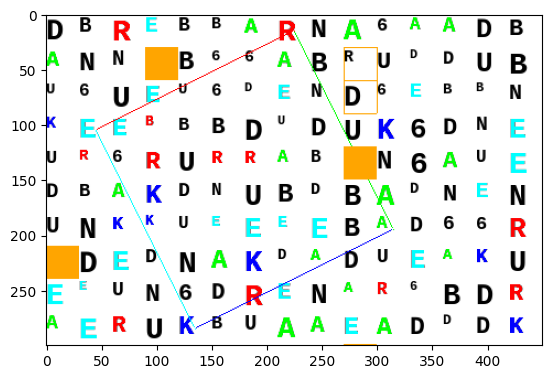

In [272]:
# Assuming `img` is the input image and `detected_addresses` contains detected letters' addresses
result_img = DrawSquareFromText_NoCollision_WithBoxes(result1, txt="KARE", addresses=addresses1, cell_size=30)

# Display the result
plt.imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB))
plt.show()
